In [1]:
import numpy as np
import pandas as pd
import os
import openpyxl
import tensorflow as tf
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from tensorflow.keras.layers import LSTM,Dense,GRU,Dropout,SimpleRNN
from sklearn.metrics import mean_squared_error
# from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
n_hours = 3
n_features = 43
train_num_24 = 2789
train_num_25 = 2892
train_num_19 = 1934

In [4]:
from os.path import join
df = pd.read_excel('rain_data.xlsx')
df.head()

,홍수사상번호,연,월,일,시간,유입량,데이터집단 1,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 38,Unnamed: 39,Unnamed: 40,데이터 집단 6,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47
0,1,2006,7,10,8,189.100000,6.4,7,7,7,...,8,2.54,122.660,6.4,7,7,8,8,2.54,122.610
1,1,2006,7,10,9,216.951962,6.3,7,8,7,...,10,2.53,122.648,7.3,7,8,10,10,2.53,122.600
2,1,2006,7,10,10,251.424419,6.4,7,9,7,...,11,2.53,122.636,8.2,7,9,10,11,2.53,122.590
3,1,2006,7,10,11,302.812199,7.3,7,10,7,...,14,2.53,122.620,11.3,9,10,15,14,2.53,122.585
4,1,2006,7,10,12,384.783406,8.2,7,12,8,...,16,2.53,122.604,14.4,12,12,18,16,2.53,122.575


In [5]:
# df_metrix 만드는 과정
df_matrix = df.to_numpy()
df_matrix = df_matrix[0:train_num_25, 5:]
print(df_matrix)

df_matrix = df_matrix.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
df_matrix = scaler.fit_transform(df_matrix)

df_matrix

[[189.1         6.4         7.        ...   8.          2.54
  122.61     ]
 [216.9519618   6.3         7.        ...  10.          2.53
  122.6      ]
 [251.4244187   6.4         7.        ...  11.          2.53
  122.59     ]
 ...
 [481.1030831   3.3854      1.        ...   1.          2.96
  137.165    ]
 [470.4581089   3.2841      1.        ...   1.          2.94
  137.18     ]
 [        nan  14.2576     32.        ...   0.          1.93
  120.515    ]]


array([[0.0086303 , 0.01948843, 0.0212766 , ..., 0.03065134, 0.09392971,
        0.15531301],
       [0.00992569, 0.01918392, 0.0212766 , ..., 0.03831417, 0.09329073,
        0.15491581],
       [0.01152899, 0.01948843, 0.0212766 , ..., 0.04214559, 0.09329073,
        0.1545186 ],
       ...,
       [0.02221129, 0.01030877, 0.00303951, ..., 0.00383142, 0.12076677,
        0.7334657 ],
       [0.0217162 , 0.0100003 , 0.00303951, ..., 0.00383142, 0.11948882,
        0.73406124],
       [       nan, 0.04341535, 0.09726444, ..., 0.        , 0.05495208,
        0.07209539]], dtype=float32)

In [6]:
# print(df_matrix)
lag = series_to_supervised(df_matrix, n_hours,1)

lag = lag.values

tmp = lag.shape[1]-42

lag = lag[:,0:tmp]
print(lag.shape)

(2888, 130)


In [7]:
n_train_hours = train_num_19
train = lag[:n_train_hours, :]
test = lag[n_train_hours:, :]

In [8]:
##1
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1934, 129) 1934 (1934,)
(1934, 3, 43) (1934,) (954, 3, 43) (954,)


In [9]:
# #testing
# model = tf.keras.Sequential()
# model.add(GRU(units = 50,
#               # dropout =0.2,
#               return_sequences = True,
#               input_shape = (train_X.shape[1],train_X.shape[2]),
#               activation = 'tanh'))

# model.add(SimpleRNN(50))

# model.add(Dense(1))

In [10]:
# testing
model = tf.keras.Sequential()
# model.add(GRU(units = 50,
#               # dropout =0.2,
#               return_sequences = True,
#               input_shape = (train_X.shape[1],train_X.shape[2]),
#               activation = 'tanh'))

# model.add(SimpleRNN(50))
model.add(LSTM(20, input_shape = (train_X.shape[1],train_X.shape[2]), activation = 'tanh', return_sequences = False))
model.add(Dense(1))

2021-08-26 17:21:12.610210: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-26 17:21:12.624880: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f968b397b90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-26 17:21:12.624894: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [11]:
# # optimizer =tf.train.AdamOptimizer(lea)
adam = tf.keras.optimizers.Adam(lr =0.01)
# early_stop = EarlyStopping(monitor='val_loss', patience=5)
# filename = os.path.join(model_path, 'tmp_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
adam = tf.keras.optimizers.Adam(lr =0.0001)
model.compile(loss='mse', optimizer='adam')

# history = model.fit(train_X, train_y, 
#                                     epochs=100, 
#                                     batch_size=16,
#                                     validation_data=(test_X, test_y), 
#                                     callbacks=[early_stop, checkpoint])
history = model.fit(train_X, train_y, 
                                    epochs=5000, 
                                    batch_size=32,
                                    validation_data=(test_X, test_y))

pred = model.predict(test_X)

Epoch 1/5000
61/61 [==============================] - 1s 10ms/step - loss: 0.0073 - val_loss: 7.7619e-04
Epoch 2/5000
61/61 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 4.7649e-04
Epoch 3/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.9297e-04 - val_loss: 4.2580e-04
Epoch 4/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.5906e-04 - val_loss: 2.7789e-04
Epoch 5/5000
61/61 [==============================] - 0s 4ms/step - loss: 3.6205e-04 - val_loss: 2.4713e-04
Epoch 6/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0120e-04 - val_loss: 1.9200e-04
Epoch 7/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7215e-04 - val_loss: 2.2227e-04
Epoch 8/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1865e-04 - val_loss: 1.5977e-04
Epoch 9/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7690e-04 - val_loss: 1.4353e-04
Epoch 10/5000
61/61 [==============

61/61 [==============================] - 0s 3ms/step - loss: 2.1433e-05 - val_loss: 1.3445e-05
Epoch 77/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8878e-05 - val_loss: 1.3429e-05
Epoch 78/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5967e-05 - val_loss: 2.1101e-05
Epoch 79/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5614e-05 - val_loss: 2.0411e-05
Epoch 80/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6899e-05 - val_loss: 1.3379e-05
Epoch 81/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7109e-05 - val_loss: 1.2763e-05
Epoch 82/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6226e-05 - val_loss: 1.5364e-05
Epoch 83/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9927e-05 - val_loss: 2.1526e-05
Epoch 84/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4955e-05 - val_loss: 1.7054e-05
Epoch 85/5000
61/61 [============

Epoch 151/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.3779e-06 - val_loss: 1.1046e-05
Epoch 152/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9784e-05 - val_loss: 1.6071e-05
Epoch 153/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.3527e-06 - val_loss: 9.6147e-06
Epoch 154/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.7050e-06 - val_loss: 8.8503e-06
Epoch 155/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.1694e-06 - val_loss: 7.2569e-06
Epoch 156/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.7270e-06 - val_loss: 9.2637e-06
Epoch 157/5000
61/61 [==============================] - 0s 4ms/step - loss: 7.3181e-06 - val_loss: 1.4242e-05
Epoch 158/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4097e-05 - val_loss: 1.3637e-05
Epoch 159/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0506e-05 - val_loss: 7.1129e-06
Epoch 160/

61/61 [==============================] - 0s 3ms/step - loss: 1.1091e-05 - val_loss: 6.4880e-06
Epoch 226/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7821e-05 - val_loss: 2.8920e-05
Epoch 227/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.1201e-06 - val_loss: 5.7607e-06
Epoch 228/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.8494e-06 - val_loss: 7.6500e-06
Epoch 229/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.3705e-06 - val_loss: 6.3631e-06
Epoch 230/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.3713e-06 - val_loss: 5.0801e-06
Epoch 231/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.9270e-06 - val_loss: 7.3853e-06
Epoch 232/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.8024e-06 - val_loss: 6.2849e-06
Epoch 233/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.8904e-06 - val_loss: 6.4570e-06
Epoch 234/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 1.8077e-06 - val_loss: 3.6952e-06
Epoch 300/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8706e-06 - val_loss: 5.6048e-06
Epoch 301/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7737e-06 - val_loss: 4.5127e-06
Epoch 302/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1098e-06 - val_loss: 4.1229e-06
Epoch 303/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1689e-06 - val_loss: 3.8440e-06
Epoch 304/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6312e-06 - val_loss: 4.3379e-06
Epoch 305/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5546e-06 - val_loss: 3.6479e-06
Epoch 306/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7875e-06 - val_loss: 3.2887e-06
Epoch 307/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1233e-06 - val_loss: 3.6579e-06
Epoch 308/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 5.7111e-06 - val_loss: 6.5681e-06
Epoch 374/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1388e-06 - val_loss: 2.7500e-06
Epoch 375/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0534e-06 - val_loss: 2.4141e-06
Epoch 376/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1755e-06 - val_loss: 3.0199e-06
Epoch 377/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.1837e-06 - val_loss: 6.7073e-06
Epoch 378/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1224e-06 - val_loss: 2.6311e-06
Epoch 379/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9219e-06 - val_loss: 2.6908e-06
Epoch 380/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8253e-06 - val_loss: 2.3690e-06
Epoch 381/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.4276e-06 - val_loss: 6.5987e-06
Epoch 382/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 4.5031e-06 - val_loss: 3.2896e-06
Epoch 448/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9092e-06 - val_loss: 4.5379e-06
Epoch 449/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0172e-06 - val_loss: 2.2884e-06
Epoch 450/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8859e-06 - val_loss: 2.2105e-06
Epoch 451/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2765e-06 - val_loss: 2.6277e-06
Epoch 452/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0646e-06 - val_loss: 2.3420e-06
Epoch 453/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0459e-06 - val_loss: 5.4188e-06
Epoch 454/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.4035e-06 - val_loss: 7.3366e-06
Epoch 455/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2068e-06 - val_loss: 2.4691e-06
Epoch 456/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 5.6779e-07 - val_loss: 2.3084e-06
Epoch 522/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7697e-06 - val_loss: 1.8945e-06
Epoch 523/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.3589e-06 - val_loss: 7.6400e-06
Epoch 524/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7405e-06 - val_loss: 4.4745e-06
Epoch 525/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0123e-06 - val_loss: 2.9002e-06
Epoch 526/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3774e-06 - val_loss: 3.7626e-06
Epoch 527/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8289e-06 - val_loss: 2.6496e-06
Epoch 528/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.5765e-07 - val_loss: 2.2508e-06
Epoch 529/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0792e-06 - val_loss: 3.2577e-06
Epoch 530/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 1.7130e-06 - val_loss: 3.3452e-06
Epoch 596/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.9819e-06 - val_loss: 1.0451e-05
Epoch 597/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.8000e-06 - val_loss: 2.1298e-06
Epoch 598/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.4162e-07 - val_loss: 2.3606e-06
Epoch 599/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.1995e-07 - val_loss: 2.0848e-06
Epoch 600/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.1993e-07 - val_loss: 1.5922e-06
Epoch 601/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.9059e-07 - val_loss: 1.8269e-06
Epoch 602/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1063e-06 - val_loss: 3.2551e-06
Epoch 603/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3206e-06 - val_loss: 5.4819e-06
Epoch 604/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 7.1027e-07 - val_loss: 1.7688e-06
Epoch 670/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.9527e-07 - val_loss: 5.5779e-06
Epoch 671/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6409e-05 - val_loss: 4.5765e-06
Epoch 672/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.0570e-06 - val_loss: 2.2379e-06
Epoch 673/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.9572e-07 - val_loss: 1.9569e-06
Epoch 674/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.5048e-07 - val_loss: 1.6976e-06
Epoch 675/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7649e-07 - val_loss: 1.7331e-06
Epoch 676/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.5195e-07 - val_loss: 2.6538e-06
Epoch 677/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.3303e-07 - val_loss: 1.6069e-06
Epoch 678/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 7.5158e-07 - val_loss: 3.0643e-06
Epoch 744/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.1845e-07 - val_loss: 1.4689e-06
Epoch 745/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8658e-07 - val_loss: 1.6224e-06
Epoch 746/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.5106e-07 - val_loss: 1.6964e-06
Epoch 747/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.1174e-07 - val_loss: 1.2084e-06
Epoch 748/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6547e-07 - val_loss: 1.3493e-06
Epoch 749/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.8323e-07 - val_loss: 1.5146e-06
Epoch 750/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2031e-06 - val_loss: 1.3817e-06
Epoch 751/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.5700e-07 - val_loss: 1.2616e-06
Epoch 752/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 3.0985e-06 - val_loss: 1.8752e-06
Epoch 818/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.1714e-07 - val_loss: 1.3325e-06
Epoch 819/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.2720e-07 - val_loss: 4.3248e-06
Epoch 820/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.8994e-07 - val_loss: 1.3206e-06
Epoch 821/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7355e-06 - val_loss: 1.4475e-06
Epoch 822/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.0083e-07 - val_loss: 1.9129e-06
Epoch 823/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.3919e-06 - val_loss: 2.0213e-06
Epoch 824/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.1528e-07 - val_loss: 3.0440e-06
Epoch 825/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0309e-06 - val_loss: 1.7193e-06
Epoch 826/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 7.2796e-07 - val_loss: 1.6549e-06
Epoch 892/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.6149e-07 - val_loss: 1.7036e-06
Epoch 893/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7455e-07 - val_loss: 1.5784e-06
Epoch 894/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.3280e-07 - val_loss: 1.4321e-06
Epoch 895/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.9125e-07 - val_loss: 1.1315e-06
Epoch 896/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.9094e-07 - val_loss: 1.7359e-06
Epoch 897/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2859e-06 - val_loss: 1.3324e-06
Epoch 898/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2075e-06 - val_loss: 2.2140e-06
Epoch 899/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1856e-06 - val_loss: 1.7960e-06
Epoch 900/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 3.1584e-07 - val_loss: 1.4235e-06
Epoch 966/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.4247e-07 - val_loss: 1.3605e-06
Epoch 967/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0702e-06 - val_loss: 9.2581e-06
Epoch 968/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3655e-06 - val_loss: 1.5853e-06
Epoch 969/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.4877e-07 - val_loss: 1.4550e-06
Epoch 970/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7435e-07 - val_loss: 1.2356e-06
Epoch 971/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2272e-07 - val_loss: 1.2869e-06
Epoch 972/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3187e-07 - val_loss: 1.3643e-06
Epoch 973/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8419e-07 - val_loss: 1.4911e-06
Epoch 974/5000
61/61 [===

61/61 [==============================] - 0s 3ms/step - loss: 9.4550e-07 - val_loss: 1.4617e-06
Epoch 1040/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0715e-07 - val_loss: 1.4792e-06
Epoch 1041/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6289e-07 - val_loss: 1.1583e-06
Epoch 1042/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.4224e-07 - val_loss: 1.2384e-06
Epoch 1043/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.6619e-07 - val_loss: 1.5903e-06
Epoch 1044/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.3040e-07 - val_loss: 1.4662e-06
Epoch 1045/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.2549e-07 - val_loss: 1.0663e-06
Epoch 1046/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.7628e-07 - val_loss: 1.1331e-06
Epoch 1047/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.8908e-07 - val_loss: 1.1870e-06
Epoch 1048/5000
6

Epoch 1113/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.9596e-07 - val_loss: 1.6077e-06
Epoch 1114/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3552e-07 - val_loss: 1.1986e-06
Epoch 1115/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.6667e-07 - val_loss: 1.6145e-06
Epoch 1116/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.8892e-07 - val_loss: 1.3294e-06
Epoch 1117/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2322e-07 - val_loss: 1.2534e-06
Epoch 1118/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7283e-07 - val_loss: 1.5153e-06
Epoch 1119/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.4134e-07 - val_loss: 1.1714e-06
Epoch 1120/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2620e-07 - val_loss: 1.0439e-06
Epoch 1121/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0133e-07 - val_loss: 1.2912e-06
E

Epoch 1187/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4659e-06 - val_loss: 1.4714e-06
Epoch 1188/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.8239e-07 - val_loss: 1.2391e-06
Epoch 1189/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4058e-06 - val_loss: 2.2709e-06
Epoch 1190/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.5857e-07 - val_loss: 1.7629e-06
Epoch 1191/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.3619e-07 - val_loss: 3.1484e-06
Epoch 1192/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.8479e-07 - val_loss: 6.2015e-06
Epoch 1193/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2344e-06 - val_loss: 1.6922e-06
Epoch 1194/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1780e-06 - val_loss: 1.1744e-06
Epoch 1195/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.0117e-07 - val_loss: 1.1800e-06
E

Epoch 1261/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2550e-07 - val_loss: 1.1224e-06
Epoch 1262/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7166e-07 - val_loss: 1.1183e-06
Epoch 1263/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0760e-06 - val_loss: 1.2506e-06
Epoch 1264/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.6130e-07 - val_loss: 1.5184e-06
Epoch 1265/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3366e-06 - val_loss: 1.4635e-06
Epoch 1266/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.8544e-07 - val_loss: 1.3043e-06
Epoch 1267/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8617e-07 - val_loss: 1.2807e-06
Epoch 1268/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.0104e-07 - val_loss: 1.3376e-06
Epoch 1269/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2980e-07 - val_loss: 1.8287e-06
E

Epoch 1335/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.3208e-07 - val_loss: 1.3773e-06
Epoch 1336/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5278e-07 - val_loss: 1.2250e-06
Epoch 1337/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2404e-07 - val_loss: 1.5029e-06
Epoch 1338/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8149e-07 - val_loss: 1.3524e-06
Epoch 1339/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6324e-07 - val_loss: 1.3452e-06
Epoch 1340/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1298e-07 - val_loss: 1.1409e-06
Epoch 1341/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8610e-06 - val_loss: 2.3587e-06
Epoch 1342/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6000e-06 - val_loss: 2.4714e-06
Epoch 1343/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.9098e-07 - val_loss: 1.3265e-06
E

Epoch 1409/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.0353e-07 - val_loss: 1.7790e-06
Epoch 1410/5000
61/61 [==============================] - 0s 4ms/step - loss: 5.1455e-07 - val_loss: 1.3654e-06
Epoch 1411/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3506e-07 - val_loss: 1.2060e-06
Epoch 1412/5000
61/61 [==============================] - 0s 4ms/step - loss: 4.7723e-07 - val_loss: 1.8142e-06
Epoch 1413/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1292e-07 - val_loss: 1.2768e-06
Epoch 1414/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7053e-07 - val_loss: 2.0952e-06
Epoch 1415/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.1213e-07 - val_loss: 1.5471e-06
Epoch 1416/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.9000e-06 - val_loss: 4.0595e-06
Epoch 1417/5000
61/61 [==============================] - 0s 5ms/step - loss: 8.8319e-06 - val_loss: 2.4334e-06
E

Epoch 1483/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.0438e-07 - val_loss: 1.1274e-06
Epoch 1484/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8826e-07 - val_loss: 1.1550e-06
Epoch 1485/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0003e-07 - val_loss: 1.4065e-06
Epoch 1486/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1502e-07 - val_loss: 9.4128e-07
Epoch 1487/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1443e-07 - val_loss: 1.3957e-06
Epoch 1488/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.1035e-06 - val_loss: 3.9192e-06
Epoch 1489/5000
61/61 [==============================] - 0s 5ms/step - loss: 2.1069e-06 - val_loss: 2.1355e-06
Epoch 1490/5000
61/61 [==============================] - 0s 4ms/step - loss: 1.6324e-06 - val_loss: 3.4729e-06
Epoch 1491/5000
61/61 [==============================] - 0s 4ms/step - loss: 2.6634e-06 - val_loss: 1.3146e-06
E

Epoch 1557/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0038e-06 - val_loss: 1.5312e-06
Epoch 1558/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2059e-07 - val_loss: 1.1574e-06
Epoch 1559/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6102e-07 - val_loss: 1.3790e-06
Epoch 1560/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.0426e-07 - val_loss: 1.6171e-06
Epoch 1561/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.4590e-07 - val_loss: 1.3162e-06
Epoch 1562/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.0441e-07 - val_loss: 9.8042e-07
Epoch 1563/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.4325e-07 - val_loss: 1.1277e-06
Epoch 1564/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.0964e-06 - val_loss: 2.3705e-06
Epoch 1565/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3098e-06 - val_loss: 1.2333e-06
E

Epoch 1631/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.9678e-07 - val_loss: 1.5546e-06
Epoch 1632/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.7972e-07 - val_loss: 1.2542e-06
Epoch 1633/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7448e-07 - val_loss: 1.5873e-06
Epoch 1634/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1778e-07 - val_loss: 1.1182e-06
Epoch 1635/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8339e-07 - val_loss: 1.1590e-06
Epoch 1636/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.9474e-07 - val_loss: 1.8802e-06
Epoch 1637/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.0047e-07 - val_loss: 1.2355e-06
Epoch 1638/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3245e-06 - val_loss: 1.5777e-06
Epoch 1639/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.9397e-07 - val_loss: 1.4179e-06
E

Epoch 1705/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8990e-07 - val_loss: 1.7076e-06
Epoch 1706/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7644e-07 - val_loss: 1.2076e-06
Epoch 1707/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0294e-06 - val_loss: 1.3189e-06
Epoch 1708/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8520e-07 - val_loss: 1.0810e-06
Epoch 1709/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1333e-07 - val_loss: 1.2542e-06
Epoch 1710/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.3861e-07 - val_loss: 1.2958e-06
Epoch 1711/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.7051e-07 - val_loss: 3.6753e-06
Epoch 1712/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4358e-06 - val_loss: 1.3935e-06
Epoch 1713/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5434e-06 - val_loss: 1.7711e-06
E

Epoch 1779/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.2468e-07 - val_loss: 1.1413e-06
Epoch 1780/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2985e-07 - val_loss: 1.0617e-06
Epoch 1781/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7767e-07 - val_loss: 1.1926e-06
Epoch 1782/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2151e-07 - val_loss: 1.2999e-06
Epoch 1783/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5821e-07 - val_loss: 1.0640e-06
Epoch 1784/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.0217e-07 - val_loss: 4.1769e-06
Epoch 1785/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0336e-06 - val_loss: 4.6625e-06
Epoch 1786/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4324e-06 - val_loss: 1.3394e-06
Epoch 1787/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2451e-07 - val_loss: 1.0717e-06
E

Epoch 1853/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1347e-07 - val_loss: 1.1318e-06
Epoch 1854/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1997e-07 - val_loss: 1.3731e-06
Epoch 1855/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.3042e-07 - val_loss: 1.4853e-06
Epoch 1856/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.6729e-07 - val_loss: 1.2647e-06
Epoch 1857/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.5855e-07 - val_loss: 8.3419e-07
Epoch 1858/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.4407e-07 - val_loss: 2.0855e-06
Epoch 1859/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.2731e-07 - val_loss: 1.0522e-06
Epoch 1860/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.2866e-07 - val_loss: 1.4040e-06
Epoch 1861/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.4640e-07 - val_loss: 1.2900e-06
E

Epoch 1927/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2166e-07 - val_loss: 1.2040e-06
Epoch 1928/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.9075e-07 - val_loss: 9.3162e-07
Epoch 1929/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.8235e-07 - val_loss: 3.6451e-06
Epoch 1930/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.7089e-07 - val_loss: 1.0321e-06
Epoch 1931/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.4678e-07 - val_loss: 1.1048e-06
Epoch 1932/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.4719e-07 - val_loss: 1.1662e-06
Epoch 1933/5000
61/61 [==============================] - 0s 5ms/step - loss: 5.7655e-07 - val_loss: 1.3040e-06
Epoch 1934/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.3985e-07 - val_loss: 1.4052e-06
Epoch 1935/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7036e-06 - val_loss: 3.8495e-06
E

Epoch 2001/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.2960e-07 - val_loss: 1.1148e-06
Epoch 2002/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.9474e-07 - val_loss: 1.3699e-06
Epoch 2003/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5609e-07 - val_loss: 1.0804e-06
Epoch 2004/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8162e-07 - val_loss: 1.3265e-06
Epoch 2005/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.0808e-07 - val_loss: 1.0057e-06
Epoch 2006/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8410e-06 - val_loss: 1.7035e-06
Epoch 2007/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0811e-06 - val_loss: 1.3543e-06
Epoch 2008/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6923e-07 - val_loss: 1.2472e-06
Epoch 2009/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8309e-07 - val_loss: 1.8754e-06
E

Epoch 2075/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1228e-07 - val_loss: 1.4020e-06
Epoch 2076/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7559e-07 - val_loss: 1.1218e-06
Epoch 2077/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2990e-07 - val_loss: 9.0547e-07
Epoch 2078/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.3573e-07 - val_loss: 9.9204e-07
Epoch 2079/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8473e-07 - val_loss: 1.3101e-06
Epoch 2080/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.4652e-06 - val_loss: 1.2831e-05
Epoch 2081/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.4547e-06 - val_loss: 1.4254e-06
Epoch 2082/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0373e-06 - val_loss: 1.4474e-06
Epoch 2083/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6377e-07 - val_loss: 1.0969e-06
E

Epoch 2149/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8074e-07 - val_loss: 1.0208e-06
Epoch 2150/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.6411e-07 - val_loss: 1.1807e-06
Epoch 2151/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.9438e-07 - val_loss: 1.2084e-06
Epoch 2152/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.9494e-06 - val_loss: 1.7445e-06
Epoch 2153/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6457e-06 - val_loss: 1.8837e-06
Epoch 2154/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.7920e-07 - val_loss: 1.0558e-06
Epoch 2155/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5186e-07 - val_loss: 9.6517e-07
Epoch 2156/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1191e-07 - val_loss: 1.2464e-06
Epoch 2157/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0301e-07 - val_loss: 1.0452e-06
E

Epoch 2223/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.3547e-07 - val_loss: 1.0117e-06
Epoch 2224/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7820e-07 - val_loss: 1.1361e-06
Epoch 2225/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2585e-07 - val_loss: 1.1353e-06
Epoch 2226/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2297e-06 - val_loss: 2.5530e-06
Epoch 2227/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.5199e-06 - val_loss: 1.6926e-06
Epoch 2228/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.9980e-07 - val_loss: 1.3555e-06
Epoch 2229/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.7839e-07 - val_loss: 9.5687e-07
Epoch 2230/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3997e-07 - val_loss: 1.0117e-06
Epoch 2231/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.4938e-07 - val_loss: 1.3963e-06
E

Epoch 2297/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.3294e-07 - val_loss: 9.0317e-07
Epoch 2298/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.9117e-07 - val_loss: 1.0955e-06
Epoch 2299/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.1994e-07 - val_loss: 1.1031e-06
Epoch 2300/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6579e-07 - val_loss: 1.1918e-06
Epoch 2301/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8743e-07 - val_loss: 8.5776e-07
Epoch 2302/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.2192e-07 - val_loss: 9.5296e-07
Epoch 2303/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.7494e-07 - val_loss: 1.3424e-06
Epoch 2304/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1385e-06 - val_loss: 7.9657e-07
Epoch 2305/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.3703e-07 - val_loss: 2.3192e-06
E

Epoch 2371/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1704e-07 - val_loss: 8.8939e-07
Epoch 2372/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.7259e-07 - val_loss: 1.6596e-06
Epoch 2373/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.1163e-07 - val_loss: 1.0855e-06
Epoch 2374/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6097e-07 - val_loss: 1.0087e-06
Epoch 2375/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.8231e-07 - val_loss: 1.1125e-06
Epoch 2376/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4936e-07 - val_loss: 1.1688e-06
Epoch 2377/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.3641e-07 - val_loss: 1.6264e-06
Epoch 2378/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.6384e-07 - val_loss: 9.8328e-07
Epoch 2379/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.4262e-08 - val_loss: 1.0324e-06
E

Epoch 2445/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0349e-07 - val_loss: 9.5263e-07
Epoch 2446/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4931e-07 - val_loss: 1.0979e-06
Epoch 2447/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.2066e-07 - val_loss: 3.5334e-06
Epoch 2448/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.1889e-06 - val_loss: 1.1843e-06
Epoch 2449/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.7198e-07 - val_loss: 1.0451e-06
Epoch 2450/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.5103e-07 - val_loss: 1.3062e-06
Epoch 2451/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.5694e-07 - val_loss: 1.2062e-06
Epoch 2452/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.2598e-07 - val_loss: 1.0904e-06
Epoch 2453/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2824e-07 - val_loss: 9.7765e-07
E

Epoch 2519/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.3108e-06 - val_loss: 1.0482e-06
Epoch 2520/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7367e-07 - val_loss: 9.0108e-07
Epoch 2521/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6308e-07 - val_loss: 1.0549e-06
Epoch 2522/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1026e-07 - val_loss: 9.4981e-07
Epoch 2523/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0939e-07 - val_loss: 1.2631e-06
Epoch 2524/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.3965e-07 - val_loss: 1.0444e-06
Epoch 2525/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2085e-07 - val_loss: 1.1369e-06
Epoch 2526/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3460e-07 - val_loss: 1.2035e-06
Epoch 2527/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3627e-07 - val_loss: 1.1827e-06
E

Epoch 2593/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9342e-06 - val_loss: 2.3287e-06
Epoch 2594/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0756e-07 - val_loss: 1.0604e-06
Epoch 2595/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3099e-07 - val_loss: 1.2015e-06
Epoch 2596/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.4660e-08 - val_loss: 1.2184e-06
Epoch 2597/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7008e-06 - val_loss: 2.2660e-06
Epoch 2598/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.6791e-07 - val_loss: 1.0122e-06
Epoch 2599/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.3314e-07 - val_loss: 1.2185e-06
Epoch 2600/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.1353e-07 - val_loss: 1.0425e-06
Epoch 2601/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.8522e-07 - val_loss: 1.3455e-06
E

Epoch 2667/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2363e-07 - val_loss: 1.0972e-06
Epoch 2668/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1990e-07 - val_loss: 1.3212e-06
Epoch 2669/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.3646e-07 - val_loss: 1.2209e-06
Epoch 2670/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.2484e-07 - val_loss: 1.1380e-06
Epoch 2671/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8783e-07 - val_loss: 1.1762e-06
Epoch 2672/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1719e-07 - val_loss: 1.0847e-06
Epoch 2673/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.6892e-07 - val_loss: 1.1864e-06
Epoch 2674/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1389e-06 - val_loss: 1.0322e-06
Epoch 2675/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2368e-07 - val_loss: 1.0323e-06
E

Epoch 2741/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.2347e-07 - val_loss: 2.1086e-06
Epoch 2742/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2554e-06 - val_loss: 1.1827e-06
Epoch 2743/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.7731e-07 - val_loss: 9.1186e-07
Epoch 2744/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2805e-07 - val_loss: 9.6745e-07
Epoch 2745/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.9372e-07 - val_loss: 1.6190e-06
Epoch 2746/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.0143e-06 - val_loss: 1.3263e-06
Epoch 2747/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.6226e-07 - val_loss: 9.7801e-07
Epoch 2748/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.0001e-07 - val_loss: 9.3767e-07
Epoch 2749/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0335e-07 - val_loss: 1.0911e-06
E

Epoch 2815/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4202e-07 - val_loss: 1.1206e-06
Epoch 2816/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5072e-07 - val_loss: 1.0935e-06
Epoch 2817/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4027e-07 - val_loss: 1.1104e-06
Epoch 2818/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1667e-07 - val_loss: 1.2851e-06
Epoch 2819/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.5685e-08 - val_loss: 1.1157e-06
Epoch 2820/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.8516e-08 - val_loss: 1.0141e-06
Epoch 2821/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0894e-07 - val_loss: 1.0606e-06
Epoch 2822/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0786e-07 - val_loss: 1.2668e-06
Epoch 2823/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.1619e-07 - val_loss: 1.3339e-06
E

Epoch 2889/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.9080e-08 - val_loss: 1.1154e-06
Epoch 2890/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0682e-07 - val_loss: 9.7715e-07
Epoch 2891/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9791e-07 - val_loss: 1.2246e-06
Epoch 2892/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.7503e-07 - val_loss: 1.1016e-06
Epoch 2893/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4047e-07 - val_loss: 1.0916e-06
Epoch 2894/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0023e-07 - val_loss: 1.4103e-06
Epoch 2895/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6308e-07 - val_loss: 9.6799e-07
Epoch 2896/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5635e-07 - val_loss: 1.1975e-06
Epoch 2897/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.8733e-07 - val_loss: 1.2808e-06
E

Epoch 2963/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.8175e-07 - val_loss: 1.2382e-06
Epoch 2964/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1996e-06 - val_loss: 2.0396e-06
Epoch 2965/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1978e-06 - val_loss: 3.2997e-06
Epoch 2966/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.2407e-07 - val_loss: 9.0874e-07
Epoch 2967/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5246e-07 - val_loss: 1.2101e-06
Epoch 2968/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2962e-07 - val_loss: 1.1312e-06
Epoch 2969/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1343e-07 - val_loss: 9.8391e-07
Epoch 2970/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3295e-07 - val_loss: 1.2267e-06
Epoch 2971/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.6372e-07 - val_loss: 1.7007e-06
E

Epoch 3037/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.1348e-08 - val_loss: 1.5594e-06
Epoch 3038/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.7211e-06 - val_loss: 2.2344e-06
Epoch 3039/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.8898e-07 - val_loss: 1.1839e-06
Epoch 3040/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.7207e-07 - val_loss: 9.6336e-07
Epoch 3041/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7753e-07 - val_loss: 9.0596e-07
Epoch 3042/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0776e-07 - val_loss: 9.4772e-07
Epoch 3043/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3006e-07 - val_loss: 1.0164e-06
Epoch 3044/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8341e-07 - val_loss: 8.6835e-07
Epoch 3045/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3332e-07 - val_loss: 1.0034e-06
E

Epoch 3111/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.1287e-07 - val_loss: 9.4902e-07
Epoch 3112/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.6494e-07 - val_loss: 1.3030e-06
Epoch 3113/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.2640e-06 - val_loss: 2.1914e-06
Epoch 3114/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1994e-07 - val_loss: 1.2331e-06
Epoch 3115/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.9330e-08 - val_loss: 1.0829e-06
Epoch 3116/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3900e-07 - val_loss: 1.5005e-06
Epoch 3117/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.8445e-07 - val_loss: 1.1418e-06
Epoch 3118/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.4262e-07 - val_loss: 1.0588e-06
Epoch 3119/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.7525e-07 - val_loss: 2.0848e-06
E

Epoch 3185/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.3735e-08 - val_loss: 9.9224e-07
Epoch 3186/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3124e-07 - val_loss: 1.0601e-06
Epoch 3187/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1163e-07 - val_loss: 9.7334e-07
Epoch 3188/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.4089e-07 - val_loss: 1.7691e-06
Epoch 3189/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2535e-06 - val_loss: 2.6592e-06
Epoch 3190/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.0382e-06 - val_loss: 1.4242e-06
Epoch 3191/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4677e-06 - val_loss: 1.1504e-06
Epoch 3192/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.4378e-07 - val_loss: 1.8177e-06
Epoch 3193/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.2373e-07 - val_loss: 1.2217e-06
E

Epoch 3259/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3329e-06 - val_loss: 1.3211e-06
Epoch 3260/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.1582e-07 - val_loss: 1.0006e-06
Epoch 3261/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.5034e-07 - val_loss: 1.3288e-06
Epoch 3262/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2803e-06 - val_loss: 2.9538e-06
Epoch 3263/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2318e-06 - val_loss: 1.3491e-06
Epoch 3264/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.4181e-07 - val_loss: 1.0141e-06
Epoch 3265/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8874e-07 - val_loss: 1.2994e-06
Epoch 3266/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5051e-07 - val_loss: 9.0325e-07
Epoch 3267/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2162e-07 - val_loss: 1.3003e-06
E

Epoch 3333/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8713e-07 - val_loss: 9.9656e-07
Epoch 3334/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3362e-07 - val_loss: 9.0763e-07
Epoch 3335/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.0167e-07 - val_loss: 1.5883e-06
Epoch 3336/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.9554e-07 - val_loss: 1.1515e-06
Epoch 3337/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.9858e-07 - val_loss: 9.8207e-07
Epoch 3338/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.8372e-07 - val_loss: 9.0982e-07
Epoch 3339/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.2482e-07 - val_loss: 1.1539e-06
Epoch 3340/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4963e-07 - val_loss: 1.0036e-06
Epoch 3341/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.4099e-07 - val_loss: 1.0674e-06
E

Epoch 3407/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.5103e-07 - val_loss: 1.0643e-06
Epoch 3408/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.6468e-08 - val_loss: 1.2647e-06
Epoch 3409/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.9603e-07 - val_loss: 1.4665e-06
Epoch 3410/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2384e-06 - val_loss: 2.0812e-06
Epoch 3411/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0229e-06 - val_loss: 9.9446e-07
Epoch 3412/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.1066e-06 - val_loss: 1.2268e-06
Epoch 3413/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.7083e-07 - val_loss: 1.2851e-06
Epoch 3414/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.1642e-07 - val_loss: 1.0540e-06
Epoch 3415/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8263e-07 - val_loss: 8.9947e-07
E

Epoch 3481/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.6618e-06 - val_loss: 1.6114e-06
Epoch 3482/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.4275e-07 - val_loss: 1.0863e-06
Epoch 3483/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2338e-07 - val_loss: 1.0379e-06
Epoch 3484/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2648e-07 - val_loss: 1.0550e-06
Epoch 3485/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.6010e-07 - val_loss: 1.0794e-06
Epoch 3486/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.9664e-07 - val_loss: 1.1225e-06
Epoch 3487/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0240e-07 - val_loss: 1.2701e-06
Epoch 3488/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4470e-07 - val_loss: 1.1702e-06
Epoch 3489/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7211e-07 - val_loss: 1.1528e-06
E

Epoch 3555/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.4750e-07 - val_loss: 1.6152e-06
Epoch 3556/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.0580e-07 - val_loss: 9.4703e-07
Epoch 3557/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.6870e-07 - val_loss: 1.1466e-06
Epoch 3558/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7237e-07 - val_loss: 9.7432e-07
Epoch 3559/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.8390e-07 - val_loss: 1.3256e-06
Epoch 3560/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2853e-07 - val_loss: 1.6254e-06
Epoch 3561/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.4893e-07 - val_loss: 9.7315e-07
Epoch 3562/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2125e-07 - val_loss: 1.1230e-06
Epoch 3563/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.1729e-07 - val_loss: 1.1950e-06
E

Epoch 3629/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0501e-07 - val_loss: 1.0968e-06
Epoch 3630/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0201e-07 - val_loss: 1.2107e-06
Epoch 3631/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.8850e-07 - val_loss: 1.1085e-06
Epoch 3632/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.2428e-08 - val_loss: 1.3001e-06
Epoch 3633/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3121e-07 - val_loss: 8.6058e-07
Epoch 3634/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.3626e-07 - val_loss: 2.9471e-06
Epoch 3635/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.8439e-07 - val_loss: 9.8632e-07
Epoch 3636/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2431e-07 - val_loss: 1.0424e-06
Epoch 3637/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3837e-07 - val_loss: 1.4882e-06
E

Epoch 3703/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3284e-07 - val_loss: 1.1947e-06
Epoch 3704/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.7889e-07 - val_loss: 6.4604e-06
Epoch 3705/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.6244e-06 - val_loss: 1.2117e-06
Epoch 3706/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.0166e-07 - val_loss: 1.2211e-06
Epoch 3707/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.5218e-07 - val_loss: 1.8665e-06
Epoch 3708/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.2782e-07 - val_loss: 1.2229e-06
Epoch 3709/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9925e-07 - val_loss: 9.3233e-07
Epoch 3710/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5418e-07 - val_loss: 1.0712e-06
Epoch 3711/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.6414e-08 - val_loss: 9.7758e-07
E

Epoch 3777/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4285e-07 - val_loss: 1.1214e-06
Epoch 3778/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.9810e-08 - val_loss: 1.1654e-06
Epoch 3779/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6152e-07 - val_loss: 1.0912e-06
Epoch 3780/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5545e-07 - val_loss: 1.0273e-06
Epoch 3781/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.7612e-07 - val_loss: 1.0625e-06
Epoch 3782/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.2839e-07 - val_loss: 1.2486e-06
Epoch 3783/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4852e-07 - val_loss: 1.0990e-06
Epoch 3784/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.5376e-07 - val_loss: 1.1892e-06
Epoch 3785/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7534e-07 - val_loss: 1.1304e-06
E

Epoch 3851/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.3257e-07 - val_loss: 1.9200e-06
Epoch 3852/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1141e-05 - val_loss: 1.0575e-05
Epoch 3853/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6915e-06 - val_loss: 1.1445e-06
Epoch 3854/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.5315e-08 - val_loss: 1.0355e-06
Epoch 3855/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.8238e-08 - val_loss: 1.0917e-06
Epoch 3856/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.5910e-08 - val_loss: 1.0219e-06
Epoch 3857/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.0100e-08 - val_loss: 1.0523e-06
Epoch 3858/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.1243e-08 - val_loss: 1.0499e-06
Epoch 3859/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.0469e-07 - val_loss: 1.0471e-06
E

Epoch 3925/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.4519e-06 - val_loss: 9.0333e-06
Epoch 3926/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.3031e-06 - val_loss: 1.6711e-06
Epoch 3927/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.6478e-07 - val_loss: 1.1017e-06
Epoch 3928/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0436e-07 - val_loss: 1.0862e-06
Epoch 3929/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.2590e-08 - val_loss: 1.1069e-06
Epoch 3930/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.6961e-08 - val_loss: 1.0634e-06
Epoch 3931/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.6655e-08 - val_loss: 1.0523e-06
Epoch 3932/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2013e-07 - val_loss: 1.2489e-06
Epoch 3933/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4930e-07 - val_loss: 1.0541e-06
E

Epoch 3999/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.1553e-06 - val_loss: 1.0824e-06
Epoch 4000/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5256e-06 - val_loss: 1.0718e-06
Epoch 4001/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2054e-07 - val_loss: 1.1784e-06
Epoch 4002/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5314e-07 - val_loss: 1.1526e-06
Epoch 4003/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.1083e-07 - val_loss: 1.2169e-06
Epoch 4004/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.2366e-07 - val_loss: 1.0140e-06
Epoch 4005/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3210e-07 - val_loss: 1.1719e-06
Epoch 4006/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.0749e-07 - val_loss: 1.3803e-06
Epoch 4007/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.4587e-07 - val_loss: 2.2479e-06
E

Epoch 4073/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.1999e-07 - val_loss: 1.1910e-06
Epoch 4074/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.0419e-07 - val_loss: 1.4799e-06
Epoch 4075/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.9097e-06 - val_loss: 1.4720e-06
Epoch 4076/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.1310e-07 - val_loss: 9.0654e-07
Epoch 4077/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7810e-07 - val_loss: 9.0542e-07
Epoch 4078/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6353e-07 - val_loss: 1.2159e-06
Epoch 4079/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2920e-07 - val_loss: 1.0715e-06
Epoch 4080/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.3191e-07 - val_loss: 1.0327e-06
Epoch 4081/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.4730e-07 - val_loss: 1.1776e-06
E

Epoch 4147/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.0691e-07 - val_loss: 1.0008e-06
Epoch 4148/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.8651e-08 - val_loss: 9.5014e-07
Epoch 4149/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4456e-07 - val_loss: 9.7257e-07
Epoch 4150/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.4146e-08 - val_loss: 9.0661e-07
Epoch 4151/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0190e-07 - val_loss: 1.1250e-06
Epoch 4152/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.6702e-07 - val_loss: 1.4619e-06
Epoch 4153/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.7837e-07 - val_loss: 9.9023e-07
Epoch 4154/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4209e-07 - val_loss: 1.0095e-06
Epoch 4155/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.2570e-07 - val_loss: 1.1207e-06
E

Epoch 4221/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.6442e-08 - val_loss: 9.8789e-07
Epoch 4222/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0798e-07 - val_loss: 1.1181e-06
Epoch 4223/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3976e-06 - val_loss: 1.5615e-06
Epoch 4224/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.3808e-06 - val_loss: 9.8624e-07
Epoch 4225/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0929e-07 - val_loss: 1.1953e-06
Epoch 4226/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4174e-07 - val_loss: 1.1775e-06
Epoch 4227/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.0445e-06 - val_loss: 1.5772e-06
Epoch 4228/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.4621e-07 - val_loss: 1.1354e-06
Epoch 4229/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.1442e-08 - val_loss: 1.2119e-06
E

Epoch 4295/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4956e-06 - val_loss: 1.0765e-06
Epoch 4296/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5070e-07 - val_loss: 1.0381e-06
Epoch 4297/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6811e-07 - val_loss: 1.1003e-06
Epoch 4298/5000
61/61 [==============================] - 0s 3ms/step - loss: 6.7821e-08 - val_loss: 1.0009e-06
Epoch 4299/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.2477e-08 - val_loss: 1.0444e-06
Epoch 4300/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.9962e-07 - val_loss: 3.3004e-06
Epoch 4301/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.9505e-07 - val_loss: 1.0997e-06
Epoch 4302/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4233e-07 - val_loss: 1.5023e-06
Epoch 4303/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.0745e-07 - val_loss: 9.2240e-07
E

Epoch 4369/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.7312e-07 - val_loss: 8.7398e-07
Epoch 4370/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.5000e-07 - val_loss: 9.5751e-07
Epoch 4371/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.5780e-07 - val_loss: 1.2572e-06
Epoch 4372/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.0683e-07 - val_loss: 1.0348e-06
Epoch 4373/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.1440e-07 - val_loss: 1.9603e-06
Epoch 4374/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.7064e-07 - val_loss: 1.0146e-06
Epoch 4375/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3992e-07 - val_loss: 1.0503e-06
Epoch 4376/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.6450e-07 - val_loss: 1.1108e-06
Epoch 4377/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3803e-07 - val_loss: 1.1047e-06
E

Epoch 4443/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.7319e-08 - val_loss: 1.0858e-06
Epoch 4444/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.8844e-08 - val_loss: 9.8159e-07
Epoch 4445/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.9950e-08 - val_loss: 9.7882e-07
Epoch 4446/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.6608e-08 - val_loss: 9.6019e-07
Epoch 4447/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.1838e-08 - val_loss: 1.2779e-06
Epoch 4448/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.1008e-07 - val_loss: 1.1234e-06
Epoch 4449/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8864e-07 - val_loss: 1.0946e-06
Epoch 4450/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.0325e-07 - val_loss: 8.6526e-07
Epoch 4451/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6166e-07 - val_loss: 1.2672e-06
E

Epoch 4517/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.4512e-08 - val_loss: 1.0237e-06
Epoch 4518/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.4303e-08 - val_loss: 1.1599e-06
Epoch 4519/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0321e-07 - val_loss: 1.1567e-06
Epoch 4520/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2036e-07 - val_loss: 1.0252e-06
Epoch 4521/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.6852e-08 - val_loss: 9.7772e-07
Epoch 4522/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0873e-06 - val_loss: 4.1212e-06
Epoch 4523/5000
61/61 [==============================] - 0s 3ms/step - loss: 4.2407e-06 - val_loss: 1.1375e-06
Epoch 4524/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.9286e-07 - val_loss: 1.2186e-06
Epoch 4525/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5473e-07 - val_loss: 1.0223e-06
E

Epoch 4591/5000
61/61 [==============================] - 0s 3ms/step - loss: 2.8489e-06 - val_loss: 1.4114e-06
Epoch 4592/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.5211e-07 - val_loss: 1.1364e-06
Epoch 4593/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9179e-07 - val_loss: 1.0408e-06
Epoch 4594/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.3414e-08 - val_loss: 1.0333e-06
Epoch 4595/5000
61/61 [==============================] - 0s 3ms/step - loss: 8.3112e-08 - val_loss: 1.0205e-06
Epoch 4596/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.3556e-08 - val_loss: 1.0194e-06
Epoch 4597/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.3037e-07 - val_loss: 1.5732e-06
Epoch 4598/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.6053e-07 - val_loss: 9.7636e-07
Epoch 4599/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0287e-07 - val_loss: 9.6347e-07
E

Epoch 4665/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.5740e-07 - val_loss: 1.0464e-06
Epoch 4666/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.2911e-07 - val_loss: 1.2732e-06
Epoch 4667/5000
61/61 [==============================] - 0s 3ms/step - loss: 9.6693e-08 - val_loss: 9.3833e-07
Epoch 4668/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5783e-07 - val_loss: 8.9931e-07
Epoch 4669/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0987e-07 - val_loss: 1.0161e-06
Epoch 4670/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.4135e-07 - val_loss: 1.2963e-06
Epoch 4671/5000
61/61 [==============================] - 0s 2ms/step - loss: 6.6426e-07 - val_loss: 1.8333e-06
Epoch 4672/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.0232e-06 - val_loss: 4.4363e-06
Epoch 4673/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.6001e-06 - val_loss: 1.2756e-06
E

Epoch 4739/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.5825e-07 - val_loss: 9.5564e-07
Epoch 4740/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.3897e-08 - val_loss: 1.0210e-06
Epoch 4741/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.6149e-08 - val_loss: 9.7014e-07
Epoch 4742/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.4489e-07 - val_loss: 1.3934e-06
Epoch 4743/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.9758e-07 - val_loss: 1.3982e-06
Epoch 4744/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7129e-07 - val_loss: 9.1887e-07
Epoch 4745/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8148e-07 - val_loss: 9.4704e-07
Epoch 4746/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.7330e-07 - val_loss: 1.0053e-06
Epoch 4747/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.0908e-07 - val_loss: 9.2840e-07
E

Epoch 4813/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1053e-06 - val_loss: 2.5039e-06
Epoch 4814/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.1020e-06 - val_loss: 1.1207e-06
Epoch 4815/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.0055e-07 - val_loss: 1.0332e-06
Epoch 4816/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.3648e-07 - val_loss: 8.8241e-07
Epoch 4817/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8784e-07 - val_loss: 1.0029e-06
Epoch 4818/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.9072e-07 - val_loss: 1.1742e-06
Epoch 4819/5000
61/61 [==============================] - 0s 2ms/step - loss: 5.9178e-07 - val_loss: 4.1580e-06
Epoch 4820/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.2171e-06 - val_loss: 1.0617e-05
Epoch 4821/5000
61/61 [==============================] - 0s 2ms/step - loss: 9.8905e-06 - val_loss: 1.6529e-06
E

Epoch 4887/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5202e-07 - val_loss: 1.9426e-06
Epoch 4888/5000
61/61 [==============================] - 0s 2ms/step - loss: 3.5348e-07 - val_loss: 1.3876e-06
Epoch 4889/5000
61/61 [==============================] - 0s 2ms/step - loss: 2.6477e-06 - val_loss: 1.0790e-06
Epoch 4890/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.8549e-07 - val_loss: 1.1909e-06
Epoch 4891/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.9871e-07 - val_loss: 1.0023e-06
Epoch 4892/5000
61/61 [==============================] - 0s 3ms/step - loss: 7.5764e-08 - val_loss: 1.0153e-06
Epoch 4893/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.2034e-06 - val_loss: 1.6716e-06
Epoch 4894/5000
61/61 [==============================] - 0s 3ms/step - loss: 3.6257e-07 - val_loss: 9.8962e-07
Epoch 4895/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.0225e-08 - val_loss: 9.7390e-07
E

Epoch 4961/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5813e-06 - val_loss: 1.1403e-06
Epoch 4962/5000
61/61 [==============================] - 0s 3ms/step - loss: 1.6705e-07 - val_loss: 9.1739e-07
Epoch 4963/5000
61/61 [==============================] - 0s 2ms/step - loss: 7.9686e-07 - val_loss: 1.1803e-06
Epoch 4964/5000
61/61 [==============================] - 0s 3ms/step - loss: 5.9934e-07 - val_loss: 9.8239e-07
Epoch 4965/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.3452e-07 - val_loss: 1.0561e-06
Epoch 4966/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.5977e-07 - val_loss: 9.9479e-07
Epoch 4967/5000
61/61 [==============================] - 0s 2ms/step - loss: 4.3099e-08 - val_loss: 1.1115e-06
Epoch 4968/5000
61/61 [==============================] - 0s 2ms/step - loss: 8.5017e-08 - val_loss: 9.2013e-07
Epoch 4969/5000
61/61 [==============================] - 0s 2ms/step - loss: 1.4809e-07 - val_loss: 1.2750e-06
E

In [12]:
RMSE = mean_squared_error(test_y,pred)**0.5
print(RMSE)

0.000936789376943964


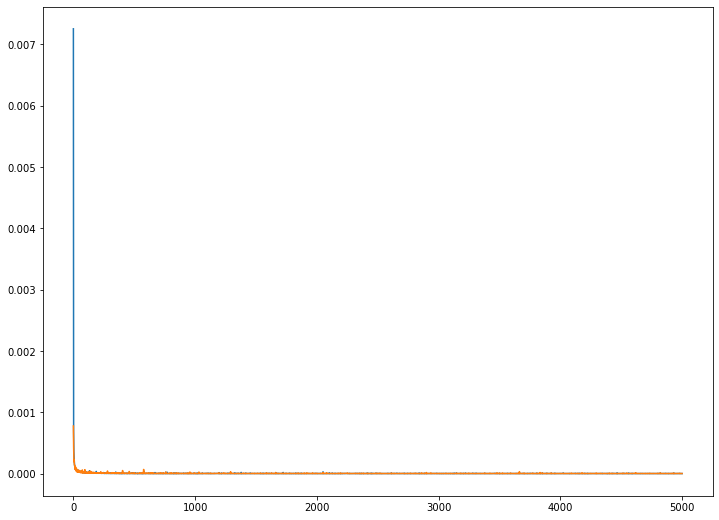

In [13]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'],label = 'train')
plt.plot(history.history['val_loss'], label = 'test')

plt.show()

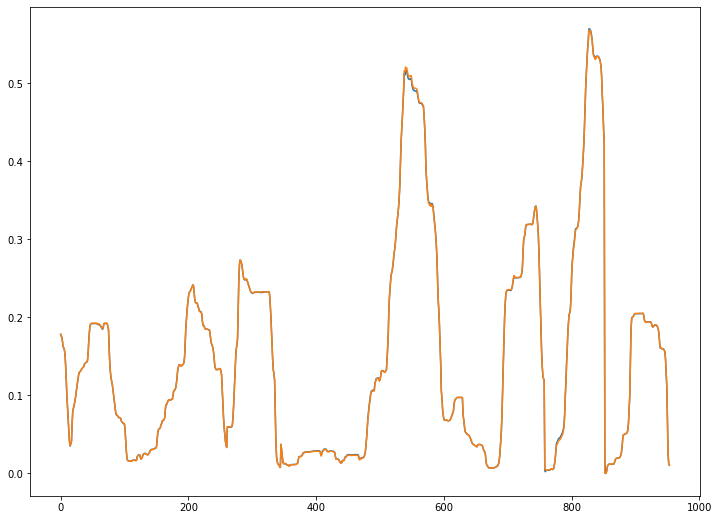

In [14]:
plt.figure(figsize=(12, 9))
plt.plot(pred,label='prediction')
plt.plot(test_y,label='real')
plt.show()